In [4]:
# Import libraries 
import pandas as pd
import re
import unicodedata
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
%matplotlib inline




# Set a style for seaborn plots
sns.set(style='whitegrid')


# # Install NLTK and download VADER lexicon
# !pip install nltk
# nltk.download('vader_lexicon')

from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Function to clean text by removing punctuation and converting to lowercase, retaining diacritics
def clean_text_for_matching(text):
    
    ##Clean the input text for matching by removing punctuation and converting to lowercase,
    ##while retaining diacritics (accents).
    
    # Remove punctuation using regex
    text = re.sub(r'[^\w\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Retain diacritics by skipping the normalization step that removes them
    return text

# Function to preprocess the lexicon and create translation dictionaries for all language pairs
def create_translation_dicts(df, languages):
    
    ##Creates translation dictionaries mapping from any source language to any target language.

    ##Args:
        #df (pd.DataFrame): The lexicon DataFrame.
        ##languages (list): List of supported languages.

   # Returns:
       ## translation_dicts (dict): Nested dictionary for translations from source to target languages.
                                   ###Structure: {source_lang: {target_lang: {source_phrase: target_phrase}}}
    
    translation_dicts = {src: {tgt: {} for tgt in languages if tgt != src} for src in languages}

    for _, row in df.iterrows():
        for src in languages:
            source_phrase = str(row[src]).strip().lower()
            if pd.isna(source_phrase) or source_phrase == '':
                continue
            for tgt in languages:
                if tgt == src:
                    continue
                target_phrase = str(row[tgt]).strip().lower()
                if pd.isna(target_phrase) or target_phrase == '':
                    continue
                translation_dicts[src][tgt][source_phrase] = target_phrase

    return translation_dicts

# Function for sentiment computation based on custom logic
def compute_sentiment_v2(scores):
    
   # Computes sentiment based on the rules:
   ## - If one score, return it.
   ## - If two scores, return the one with the higher absolute value.
   ## - If three or more scores, return the average of the majority group (positive or negative).
   
    if len(scores) == 1:
        return scores[0]
    elif len(scores) == 2:
        return max(scores, key=abs)
    else:
        positive_scores = [s for s in scores if s > 0]
        negative_scores = [s for s in scores if s < 0]
        if len(positive_scores) >= len(negative_scores):
            return sum(positive_scores) / len(positive_scores) if positive_scores else 0
        else:
            return sum(negative_scores) / len(negative_scores) if negative_scores else 0

# Function to translate and analyze sentiments, maintaining sentence structure and supporting multiple languages
def translate_analyze_sentiments_with_vader(text, source_lang, target_lang,
                                            translation_dicts, sentiment_averages, all_sentiments,
                                            vader_analyzer):
    
    #Translates the input text from source_lang to target_lang, computes custom sentiment scores,
   #and computes VADER sentiment scores.

    #Maintains the original sentence structure by processing the text sequentially.

    #Args:
      ##  text (str): The input sentence to translate.
      ##  source_lang (str): The source language of the input sentence.
      ##  target_lang (str): The desired target language for translation.
      ##  translation_dicts (dict): Nested dictionary for translations.
      ##  sentiment_averages (dict): Average sentiment scores for each phrase in each language.
      ##  all_sentiments (dict): All sentiment scores for each phrase in each language.
      ##  vader_analyzer (SentimentIntensityAnalyzer): VADER sentiment analyzer instance.

    #Returns:
       ## dict: Contains custom translated text, custom sentiment scores, VADER sentiment scores.
   
    # Ensure language codes are lowercase
    source_lang = source_lang.lower()
    target_lang = target_lang.lower()

    if source_lang not in translation_dicts or target_lang not in translation_dicts[source_lang]:
        print(f"Translation from '{source_lang}' to '{target_lang}' is not supported.")
        return {
            "translated_text": "",
            "total_score_avg": 0,
            "word_scores_avg": "",
            "sentiment_avg": "neutral",
            "total_score_v2": 0,
            "word_scores_v2": "",
            "sentiment_v2": "neutral",
            "vader_positive": 0,
            "vader_negative": 0,
            "vader_neutral": 0,
            "vader_compound": 0,
            "vader_sentiment": "neutral"
        }

    # Clean the input text
    cleaned_text = clean_text_for_matching(text)

    # Tokenize the text into words
    words = cleaned_text.split()
    translated_sentence = []
    total_score_avg = 0
    total_score_v2 = 0
    word_scores_avg = []
    word_scores_v2 = []

    i = 0
    while i < len(words):
        # Attempt to match the longest possible phrase
        max_phrase_length = 0
        matched_phrase = None
        translated_phrase = None
        phrase_score_avg = 0
        phrase_scores_v2 = 0

        # Define a reasonable maximum phrase length (e.g., up to 5 words)
        max_possible_length = min(5, len(words) - i)

        for j in range(max_possible_length, 0, -1):
            phrase = ' '.join(words[i:i+j])
            if phrase in translation_dicts[source_lang][target_lang]:
                max_phrase_length = j
                matched_phrase = phrase
                translated_phrase = translation_dicts[source_lang][target_lang][phrase]
                phrase_score_avg = sentiment_averages[source_lang].get(phrase, 0)
                phrase_scores = all_sentiments[source_lang].get(phrase, [])
                phrase_scores_v2 = compute_sentiment_v2(phrase_scores)
                break  # Stop at the first (longest) match

        if matched_phrase:
            # Append the translated phrase
            translated_sentence.append(translated_phrase)
            # Update sentiment scores
            total_score_avg += phrase_score_avg
            total_score_v2 += phrase_scores_v2
            # Store word:score pairs
            word_scores_avg.append(f"{matched_phrase}:{phrase_score_avg}")
            word_scores_v2.append(f"{matched_phrase}:{phrase_scores_v2}")
            # Move past the matched phrase
            i += max_phrase_length
        else:
            # No phrase matched; translate single word
            word = words[i]
            translated_word = translation_dicts[source_lang][target_lang].get(word, word)
            translated_sentence.append(translated_word)
            # Retrieve sentiment scores for the word
            word_score_avg = sentiment_averages[source_lang].get(word, 0)
            word_scores = all_sentiments[source_lang].get(word, [])
            word_score_v2 = compute_sentiment_v2(word_scores)
            # Update sentiment scores
            total_score_avg += word_score_avg
            total_score_v2 += word_score_v2
            # Store word:score pairs
            word_scores_avg.append(f"{word}:{word_score_avg}")
            word_scores_v2.append(f"{word}:{word_score_v2}")
            # Move to the next word
            i += 1

    # Combine translated words/phrases back into a sentence
    translated_text = ' '.join(translated_sentence).strip()

    # Determine overall sentiment using average method
    sentiment_avg = "neutral"
    if total_score_avg > 0.05:
        sentiment_avg = "positive"
    elif total_score_avg < -0.05:
        sentiment_avg = "negative"

    # Determine overall sentiment using compute_sentiment_v2 method
    sentiment_v2 = "neutral"
    if total_score_v2 > 0.05:
        sentiment_v2 = "positive"
    elif total_score_v2 < -0.05:
        sentiment_v2 = "negative"

    # Join word scores into a single string separated by semicolons
    word_scores_avg_str = '; '.join(word_scores_avg)
    word_scores_v2_str = '; '.join(word_scores_v2)

    # Compute VADER sentiment scores
    vader_scores = vader_analyzer.polarity_scores(text)
    vader_positive = vader_scores['pos']
    vader_negative = vader_scores['neg']
    vader_neutral = vader_scores['neu']
    vader_compound = vader_scores['compound']

    # Determine VADER sentiment based on compound score
    if vader_compound >= 0.05:
        vader_sentiment = "positive"
    elif vader_compound <= -0.05:
        vader_sentiment = "negative"
    else:
        vader_sentiment = "neutral"

    # Return all required fields
    return {
        "translated_text": translated_text,
        "total_score_avg": total_score_avg,
        "word_scores_avg": word_scores_avg_str,
        "sentiment_avg": sentiment_avg,
        "total_score_v2": total_score_v2,
        "word_scores_v2": word_scores_v2_str,
        "sentiment_v2": sentiment_v2,
        "vader_positive": vader_positive,
        "vader_negative": vader_negative,
        "vader_neutral": vader_neutral,
        "vader_compound": vader_compound,
        "vader_sentiment": vader_sentiment
    }

# Function to safely translate and analyze sentiment for each row
def safe_translate_and_analyze_sentiments_with_vader(row, translation_dicts, sentiment_averages, all_sentiments, vader_analyzer):
    
   # Safely translates and analyzes sentiment for a given row in the DataFrame.
   # Handles missing or invalid data gracefully by returning default values.

  # Args:
    ## row (pd.Series): A row from the test corpus DataFrame.
       ## translation_dicts (dict): Nested dictionary for translations.
       ## sentiment_averages (dict): Average sentiment scores for each phrase in each language.
       ## all_sentiments (dict): All sentiment scores for each phrase in each language.
        # vader_analyzer (SentimentIntensityAnalyzer): VADER sentiment analyzer instance.

    #Returns:
        #pd.Series: Series containing both custom and VADER sentiment analysis results.
    
    text = row.get('sentence', '')
    source_lang = row.get('source_language', '')
    target_lang = row.get('target_language', '')
    if isinstance(text, str) and isinstance(source_lang, str) and isinstance(target_lang, str):
        return pd.Series(
            translate_analyze_sentiments_with_vader(
                text,
                source_lang,
                target_lang,
                translation_dicts,
                sentiment_averages,
                all_sentiments,
                vader_analyzer
            )
        )
    else:
        # Return default values if inputs are not valid
        return pd.Series({
            "translated_text": "",
            "total_score_avg": 0,
            "word_scores_avg": "",
            "sentiment_avg": "neutral",
            "total_score_v2": 0,
            "word_scores_v2": "",
            "sentiment_v2": "neutral",
            "vader_positive": 0,
            "vader_negative": 0,
            "vader_neutral": 0,
            "vader_compound": 0,
            "vader_sentiment": "neutral"
        })



# Initialize VADER sentiment analyzer
vader_analyzer = SentimentIntensityAnalyzer()

# Define the file paths (Use raw strings to handle backslashes in Windows paths)
lexicon_path = r"C:\Users\ryand\Desktop\2024\Honours\Modules\S2\INF791\Assignment\Assignment 3\Translated Lexiocon\AA_FINAL FINAL FINAL\corrected_lexicon.xlsx"
corpus_path = r"C:\Users\ryand\Desktop\2024\Honours\Modules\S2\INF791\Assignment\Assignment 3\Translated Lexiocon\AA_FINAL FINAL FINAL\test_corpus.xlsx"
# Load the lexicon file
try:
    df = pd.read_excel(lexicon_path)
    print(f"Successfully loaded lexicon from: {lexicon_path}")
except FileNotFoundError:
    print(f"Lexicon file not found at: {lexicon_path}")
    raise

# Load the test corpus file
try:
    test_corpus_df = pd.read_excel(corpus_path)
    print(f"Successfully loaded test corpus from: {corpus_path}")
except FileNotFoundError:
    print(f"Test corpus file not found at: {corpus_path}")
    raise

# Adjust column names for consistency and include 'sepedi'
# Expected original columns: ['CILUBA', 'FRANCAIS', 'ENGLISH', 'AFRIKAANS', 'ZULU', 'Sepedi', 'SCORE', 'SENTIMENT', 'NATURE']
df.columns = ['ciluba', 'french', 'english', 'afrikaans', 'zulu', 'sepedi', 'score', 'sentiment', 'nature']

# Define supported languages based on lexicon columns
supported_languages = ['french', 'afrikaans', 'zulu', 'ciluba', 'sepedi', 'english']

# Verify that all required language columns exist
missing_languages = [lang for lang in supported_languages if lang not in df.columns]
if missing_languages:
    raise KeyError(f"The following required language columns are missing in the lexicon: {missing_languages}")

# Create the translation dictionaries for all language pairs
translation_dicts = create_translation_dicts(df, supported_languages)
print("Translation dictionaries created successfully.")

# Calculate average sentiment scores and collect all sentiment scores for each language
# Structure: sentiment_averages[language][phrase] = average_score
#            all_sentiments[language][phrase] = [score1, score2, ...]
sentiment_averages = {}
all_sentiments = {}

for lang in supported_languages:
    sentiment_averages[lang] = df.groupby(lang)['score'].mean().to_dict()
    all_sentiments[lang] = df.groupby(lang)['score'].apply(list).to_dict()

print("Sentiment scores calculated successfully.")

# Apply the sentiment analysis to the test corpus DataFrame
test_corpus_df[['translated_text',
               'total_score_avg',
               'word_scores_avg',
               'sentiment_avg',
               'total_score_v2',
               'word_scores_v2',
               'sentiment_v2',
               'vader_positive',
               'vader_negative',
               'vader_neutral',
               'vader_compound',
               'vader_sentiment']] = test_corpus_df.apply(
    lambda row: safe_translate_and_analyze_sentiments_with_vader(
        row,
        translation_dicts,
        sentiment_averages,
        all_sentiments,
        vader_analyzer
    ), axis=1
)

print("Sentiment analysis (Custom & VADER) applied to test corpus.")

# Define the desired column order
desired_order = [
    'sentence',
    'source_language',
    'target_language',
    'total_score_avg',
    'word_scores_avg',
    'sentiment_avg',
    'total_score_v2',
    'word_scores_v2',
    'sentiment_v2',
    'translated_text',
    'vader_positive',
    'vader_negative',
    'vader_neutral',
    'vader_compound',
    'vader_sentiment'
]

# Reorder the DataFrame columns accordingly
test_corpus_df = test_corpus_df[desired_order + [col for col in test_corpus_df.columns if col not in desired_order]]

# Display the updated DataFrame with the translations and sentiment analysis
print("Preview of Sentiment Analysis Results:")
display(test_corpus_df.head(50))

# Optional: Analyze the correlation between custom sentiment and VADER sentiment
# For example, using the 'sentiment_v2' and 'vader_sentiment' columns

# Map sentiment categories to numerical values for correlation
sentiment_mapping = {'negative': -1, 'neutral': 0, 'positive': 1}
test_corpus_df['custom_sentiment_numeric'] = test_corpus_df['sentiment_v2'].map(sentiment_mapping)
test_corpus_df['vader_sentiment_numeric'] = test_corpus_df['vader_sentiment'].map(sentiment_mapping)



Successfully loaded lexicon from: C:\Users\ryand\Desktop\2024\Honours\Modules\S2\INF791\Assignment\Assignment 3\Translated Lexiocon\AA_FINAL FINAL FINAL\corrected_lexicon.xlsx
Successfully loaded test corpus from: C:\Users\ryand\Desktop\2024\Honours\Modules\S2\INF791\Assignment\Assignment 3\Translated Lexiocon\AA_FINAL FINAL FINAL\test_corpus.xlsx
Translation dictionaries created successfully.
Sentiment scores calculated successfully.
Sentiment analysis (Custom & VADER) applied to test corpus.
Preview of Sentiment Analysis Results:


,sentence,source_language,target_language,total_score_avg,word_scores_avg,sentiment_avg,total_score_v2,word_scores_v2,sentiment_v2,translated_text,vader_positive,vader_negative,vader_neutral,vader_compound,vader_sentiment
0,I want food.,english,zulu,6.500000,i:0.0; want:3.5; food:3.0,positive,7.000000,i:0; want:4; food:3,positive,mina funa ukudla,0.565,0.000,0.435,0.0772,positive
1,I want to dance with you.,english,zulu,5.900000,i:0.0; want:3.5; to dance:2.4; with:0.0; you:0.0,positive,6.400000,i:0; want:4; to dance:2.4; with:0; you:0,positive,mina funa ukudansa nabo wena,0.245,0.000,0.755,0.0772,positive
2,Come to uncle Josh.,english,zulu,7.666667,come:3.3333333333333335; to:0.0; uncle:4.33333...,positive,7.666667,come:3.3333333333333335; to:0; uncle:4.3333333...,positive,fika uku umalume josh,0.000,0.000,1.000,0.0000,neutral
3,I am happy today.,english,zulu,9.166667,i am:3.0; happy:4.5; today:1.6666666666666667,positive,10.500000,i am:3; happy:5; today:2.5,positive,nginguye jabulile namhlanje,0.649,0.000,0.351,0.5719,positive
4,What do you want to watch?,english,zulu,6.750000,what:0.0; do:1.5; you:0.0; want:3.5; to:0.0; w...,positive,7.750000,what:0; do:2.0; you:0; want:4; to:0; watch:1.75,positive,yini yenza wena funa uku buka,0.206,0.000,0.794,0.0772,positive
5,Waiting to dance to accompany you.,english,zulu,8.900000,waiting:2.5; to dance:2.4; to accompany:4.0; y...,positive,9.400000,waiting:3; to dance:2.4; to accompany:4; you:0,positive,lindizayo ukudansa ukuhambisana wena,0.000,0.000,1.000,0.0000,neutral
6,Have you eaten?,english,zulu,6.500000,have:3.0; you:0.0; eaten:3.5,positive,9.000000,have:3; you:0; eaten:6,positive,hamba wena udleke,0.000,0.000,1.000,0.0000,neutral
7,Thank you.,english,french,5.000000,thank you:5.0,positive,5.000000,thank you:5,positive,merci,0.714,0.000,0.286,0.3612,positive
8,I am happy today.,english,sepedi,9.166667,i am:3.0; happy:4.5; today:1.6666666666666667,positive,10.500000,i am:3; happy:5; today:2.5,positive,ke nna thabile lehono,0.649,0.000,0.351,0.5719,positive
9,Waiting to dance to accompany you.,english,sepedi,8.900000,waiting:2.5; to dance:2.4; to accompany:4.0; y...,positive,9.400000,waiting:3; to dance:2.4; to accompany:4; you:0,positive,letile go bina go felegetša wena,0.000,0.000,1.000,0.0000,neutral


In [2]:
# Table 1: Translations
table1 = test_corpus_df[['sentence', 'source_language', 'target_language', 'translated_text']]
print("### Table 1: Translations")
display(table1.head(50))  
# Table 2: Sentiment Analysis Results
table2 = test_corpus_df[[
    'total_score_avg',
    'word_scores_avg',
    'sentiment_avg',
    'total_score_v2',
    'word_scores_v2',
    'sentiment_v2',
    'vader_compound',
    'vader_sentiment'
]]
print("### Table 2: Sentiment Analysis Results")
display(table2.head(50)) 

### Table 1: Translations


,sentence,source_language,target_language,translated_text
0,I want food.,english,zulu,mina funa ukudla
1,I want to dance with you.,english,zulu,mina funa ukudansa nabo wena
2,Come to uncle Josh.,english,zulu,fika uku umalume josh
3,I am happy today.,english,zulu,nginguye jabulile namhlanje
4,What do you want to watch?,english,zulu,yini yenza wena funa uku buka
5,Waiting to dance to accompany you.,english,zulu,lindizayo ukudansa ukuhambisana wena
6,Have you eaten?,english,zulu,hamba wena udleke
7,Thank you.,english,french,merci
8,I am happy today.,english,sepedi,ke nna thabile lehono
9,Waiting to dance to accompany you.,english,sepedi,letile go bina go felegetša wena


### Table 2: Sentiment Analysis Results


,total_score_avg,word_scores_avg,sentiment_avg,total_score_v2,word_scores_v2,sentiment_v2,vader_compound,vader_sentiment
0,6.500000,i:0.0; want:3.5; food:3.0,positive,7.000000,i:0; want:4; food:3,positive,0.0772,positive
1,5.900000,i:0.0; want:3.5; to dance:2.4; with:0.0; you:0.0,positive,6.400000,i:0; want:4; to dance:2.4; with:0; you:0,positive,0.0772,positive
2,7.666667,come:3.3333333333333335; to:0.0; uncle:4.33333...,positive,7.666667,come:3.3333333333333335; to:0; uncle:4.3333333...,positive,0.0000,neutral
3,9.166667,i am:3.0; happy:4.5; today:1.6666666666666667,positive,10.500000,i am:3; happy:5; today:2.5,positive,0.5719,positive
4,6.750000,what:0.0; do:1.5; you:0.0; want:3.5; to:0.0; w...,positive,7.750000,what:0; do:2.0; you:0; want:4; to:0; watch:1.75,positive,0.0772,positive
5,8.900000,waiting:2.5; to dance:2.4; to accompany:4.0; y...,positive,9.400000,waiting:3; to dance:2.4; to accompany:4; you:0,positive,0.0000,neutral
6,6.500000,have:3.0; you:0.0; eaten:3.5,positive,9.000000,have:3; you:0; eaten:6,positive,0.0000,neutral
7,5.000000,thank you:5.0,positive,5.000000,thank you:5,positive,0.3612,positive
8,9.166667,i am:3.0; happy:4.5; today:1.6666666666666667,positive,10.500000,i am:3; happy:5; today:2.5,positive,0.5719,positive
9,8.900000,waiting:2.5; to dance:2.4; to accompany:4.0; y...,positive,9.400000,waiting:3; to dance:2.4; to accompany:4; you:0,positive,0.0000,neutral


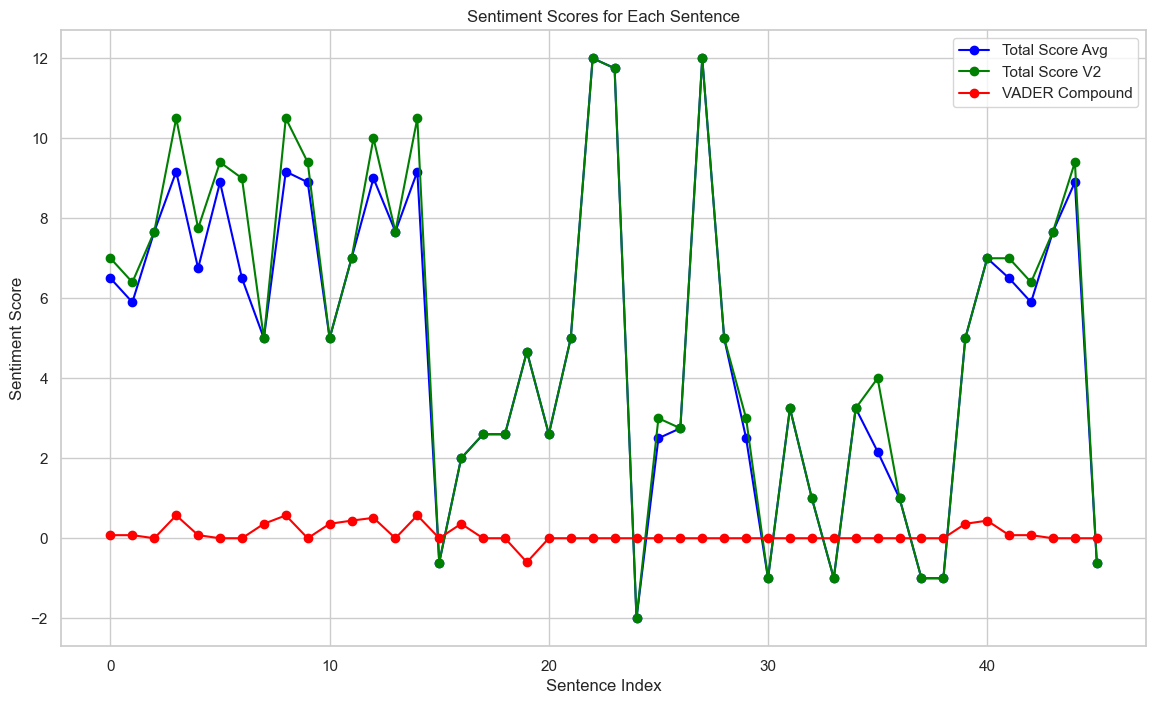

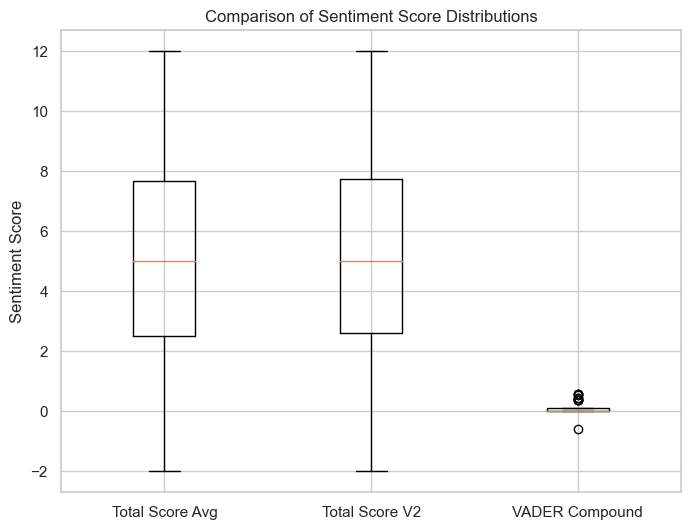

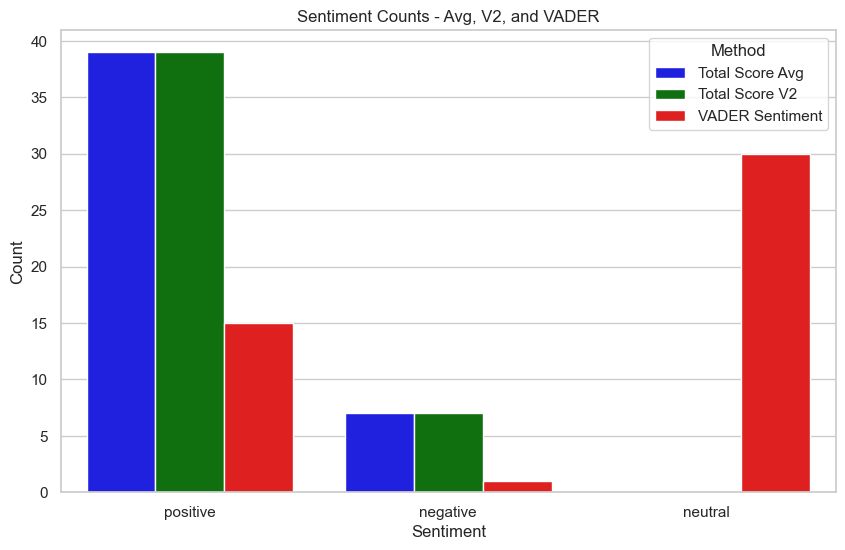

In [5]:


# Plot sentiment scores for all sentences
plt.figure(figsize=(14, 8))
plt.plot(test_corpus_df.index, test_corpus_df['total_score_avg'], label='Total Score Avg', color='blue', marker='o')
plt.plot(test_corpus_df.index, test_corpus_df['total_score_v2'], label='Total Score V2', color='green', marker='o')
plt.plot(test_corpus_df.index, test_corpus_df['vader_compound'], label='VADER Compound', color='red', marker='o')
plt.title('Sentiment Scores for Each Sentence')
plt.xlabel('Sentence Index')
plt.ylabel('Sentiment Score')
plt.legend()
plt.grid(True)
plt.show()



# Box plots to compare the distributions
plt.figure(figsize=(8, 6))
data_to_plot = [
    test_corpus_df['total_score_avg'],
    test_corpus_df['total_score_v2'],
    test_corpus_df['vader_compound']
]
plt.boxplot(data_to_plot, labels=['Total Score Avg', 'Total Score V2', 'VADER Compound'])
plt.title('Comparison of Sentiment Score Distributions')
plt.ylabel('Sentiment Score')
plt.show()



# Prepare data for sentiment counts by melting the DataFrame
count_data = pd.melt(
    test_corpus_df,
    value_vars=['sentiment_avg', 'sentiment_v2', 'vader_sentiment'],
    var_name='Method',
    value_name='Sentiment'
)

# Define a color palette for the different methods
palette = {
    'sentiment_avg': 'blue',
    'sentiment_v2': 'green',
    'vader_sentiment': 'red'
}

# Plot sentiment counts
plt.figure(figsize=(10, 6))
ax = sns.countplot(
    x='Sentiment',
    hue='Method',
    data=count_data,
    palette=palette
)
plt.title('Sentiment Counts - Avg, V2, and VADER')
plt.xlabel('Sentiment')
plt.ylabel('Count')

# Ensure y-axis displays whole numbers
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

# Update legend labels
plt.legend(title='Method', labels=['Total Score Avg', 'Total Score V2', 'VADER Sentiment'])
plt.show()
